<a href="https://colab.research.google.com/github/voirinprof/python-geo-colab/blob/main/Analyse_temporelle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutoriel : Analyse temporelle d'un indicateur avec Google Earth Engine et Google Colab

### Objectif

1. Configurer notre environnement.
2. Charger une collection d'images satellites avec GEE (période d'analyse).
3. Calculer un indice de végétation (NDVI) pour chaque année.
4. Visualiser les résultats.


Prérequis : Un compte Google (pour Colab, GEE et Google Drive).

## Installer GEE dans Colab

In [1]:
# Installer et configurer GEE
!pip install earthengine-api  # Installe l'API GEE

## Importer les libs utiles

In [2]:
import ee  # Importe la bibliothèque GEE
import geemap
import matplotlib.pyplot as plt
import pandas as pd

# Authentification (exécutez cette cellule et suivez les instructions)
ee.Authenticate()  # Ouvre une fenêtre pour se connecter à votre compte Google
ee.Initialize(project="gmq580")  # Initialise GEE avec vos identifiants

# il peut être nécessaire de créer un projet dans Google Cloud Console

print("GEE est prêt à être utilisé !")

GEE est prêt à être utilisé !


## Débuter votre analyse

Définir une zone d’intérêt

In [3]:
# On va utiliser la localisation de Sherbrooke
region = ee.Geometry.Point([-71.888351, 45.404476])  # Centre sur Sherbrooke
area = region.buffer(10000)  # Crée une zone tampon de 10 km autour du point

# Période d'analyse : 2019 à 2023
years = ee.List.sequence(2019, 2023)  # Liste des années

Fonction pour calculer le NDVI annuel

In [4]:
# Fonction pour calculer le NDVI moyen annuel
def calculate_annual_ndvi(year):
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year, 12, 31)

    # Charger Sentinel-2 et filtrer
    collection = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
                  .filterBounds(area) \
                  .filterDate(start_date, end_date) \
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
                  .median()  # Médiane pour réduire les variations

    # Calculer le NDVI
    ndvi = collection.normalizedDifference(['B8', 'B4']).rename('NDVI')

    # Réduire pour obtenir la moyenne dans la zone
    ndvi_mean = ndvi.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=area,
        scale=10
    ).get('NDVI')

    # Retourner l'année et la valeur NDVI
    return ee.Feature(None, {'year': year, 'ndvi': ndvi_mean})

# Appliquer la fonction à chaque année
annual_ndvi = ee.FeatureCollection(years.map(calculate_annual_ndvi))

Extraire et visualiser la série temporelle

NDVI moyen par année :
       ndvi  year
0  0.596297  2019
1  0.509144  2020
2  0.492568  2021
3  0.474547  2022
4  0.531103  2023


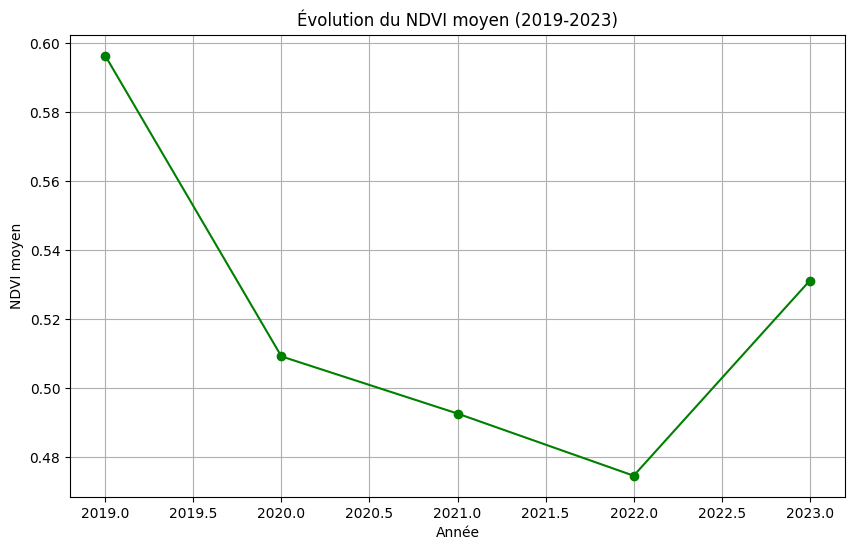

In [5]:
# Convertir les résultats en DataFrame pandas
ndvi_data = annual_ndvi.getInfo()['features']
df = pd.DataFrame([f['properties'] for f in ndvi_data])

# Afficher le tableau
print("NDVI moyen par année :")
print(df)

# Tracer la série temporelle
plt.figure(figsize=(10, 6))
plt.plot(df['year'], df['ndvi'], marker='o', linestyle='-', color='green')
plt.title('Évolution du NDVI moyen (2019-2023)')
plt.xlabel('Année')
plt.ylabel('NDVI moyen')
plt.grid(True)
plt.show()